# Solve the Linear Regression using Gradient Descent (with full-batch)

* Regression includes many techniques for modeling and analyzing several variables, when the focus is on the relationship between a dependent variable and one or more independent variables (or 'predictors'). [Ref.: Wikipedia, "Regression analysis" page](https://en.wikipedia.org/wiki/Regression_analysis)

$$y_{\textrm{pred}} = \boldsymbol{w}^{\top}\boldsymbol{x} + b$$
or
$$y_{\textrm{pred}} = w_{0} + w_{1} x_{1} + w_{2} x_{2} + \cdots + w_{d} x_{d},$$
where $w_{0} = b$.

* $\mathbf{x} = [x_{1}, x_{2}, \cdots, x_{d}]^{\top}$
* $\mathbf{w} = [w_{1}, w_{2}, \cdots, w_{d}]^{\top}$
* Loss function: $\mathcal{L} = \sum^{N} (y_{\textrm{pred}} - y)^{2}$
  * where $N$ is a number of examples

## Import

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
%matplotlib inline

import math

from itertools import zip_longest

## Задание 1

In [2]:
class ConstantScheduler:
    def __init__(self, lr: float):
        self.lr = lr

    def step(self) -> float:
        return self.lr

In [3]:
class ExponentialScheduler:
    def __init__(self, lr: float, gamma: float, every: int):
        self.lr = lr
        self.gamma = gamma
        self.every = every
        self.steps = 0

    def step(self) -> float:
        self.steps += 1
        if self.steps % self.every == 0:
            self.lr *= self.gamma
        return self.lr

In [4]:
class LinearScheduler:
    def __init__(self, lr: float, diff: float, every: int, min_lr: float = 0.00001):
        super().__init__(lr)
        self.every = every
        self.steps = 0
        self.diff = diff
        self.min_lr = min_lr

    def step(self) -> float:
        self.steps += 1
        if self.steps % self.every and self.lr > self.min_lr:
            self.lr = max(self.min_lr, self.lr - self.diff)

        return self.lr

In [5]:
class SGD(object):
  def __init__(self, data_x, data_y, scheduler=None, learning_rate=0.001, batch_size=1, features=2, N = 10):
    if scheduler == None:
      scheduler = ConstantScheduler(learning_rate)
    self.w = np.random.uniform(size=features)
    self.b = np.random.uniform(size=1)
    self.N = N
    self.x = data_x
    self.y = data_y
    self.lr = learning_rate
    self.batch_size = batch_size
    self.scheduler = scheduler
    
    # for accumulation of loss and path (w, b)
    self.loss_history = []
  
  def inference(self, x):
    y_pred = x @ self.w + self.b
    return y_pred
  
  def loss_for_plot(self, w, b):
    y_pred = np.matmul(np.expand_dims(self.x, axis=1), np.expand_dims(w, axis=0)) + b
    loss_for_plot = 0.5 * (y_pred - np.expand_dims(self.y, axis=1))**2
    loss_for_plot = np.mean(loss_for_plot, axis=0)
    return loss_for_plot
  
  def loss_fn(self, labels, predictions):
    loss = 0.5 * np.mean((predictions - labels)**2)
    return loss
  
  def loss_derivative(self, inputs, labels, predictions):
    y_diff = predictions - labels
    # print(f'{y_diff.shape=}')
    # print(f'{inputs.shape=}')
    dw = (1.0 / len(self.x)) * np.matmul(np.transpose(inputs), y_diff)
    # dw = np.mean((y_pred - y) @ x)
    db = (1.0 / len(self.x)) * y_diff
    return dw, db
    # dw = np.mean((predictions - labels) @ inputs)
    # db = np.mean(predictions - labels)
    # return dw, db
  
  def weights_update(self, dw, db):
    self.w = self.w - self.lr * dw
    self.b = self.b - self.lr * db
    
  def update_lr(self):
    self.lr = self.scheduler.step()
    
    
  def train(self, max_epochs):
    total_steps = 1
    num_batches_per_epoch = math.floor(len(self.x) / self.batch_size)
    for epoch in range(max_epochs):
      cur_loss = 0
      shuffle_index = np.random.permutation(self.N)
      #shuffle_index = np.range(N) # non-shuffling case
      
      for step in range(num_batches_per_epoch):
        batch_x = self.x[shuffle_index[step*self.batch_size:(step+1)*self.batch_size]]
        batch_y = self.y[shuffle_index[step*self.batch_size:(step+1)*self.batch_size]]
        
        self.y_pred = self.inference(batch_x)
        self.loss = self.loss_fn(batch_y, self.y_pred)
        
        cur_loss += self.loss
        
      
        #inputs, labels, predictions
        self.dw, self.db = self.loss_derivative(batch_x, batch_y, self.y_pred)
        self.weights_update(self.dw, self.db)
        # print(f"epochs: {epoch}  total_steps: {total_steps}  loss: {self.loss:.6f}")
      
        pre_loss = self.loss
        total_steps += 1
      
      self.update_lr()
      
      self.loss_history.append(cur_loss / num_batches_per_epoch)
      
      
      
      # if epoch % 100 == 0:
      #   print(f'{epoch=} {self.loss=} {self.lr=}')
        
    # print("End of training")
    # print(f"total_steps: {total_steps-1}  loss: {self.loss:.6f}")

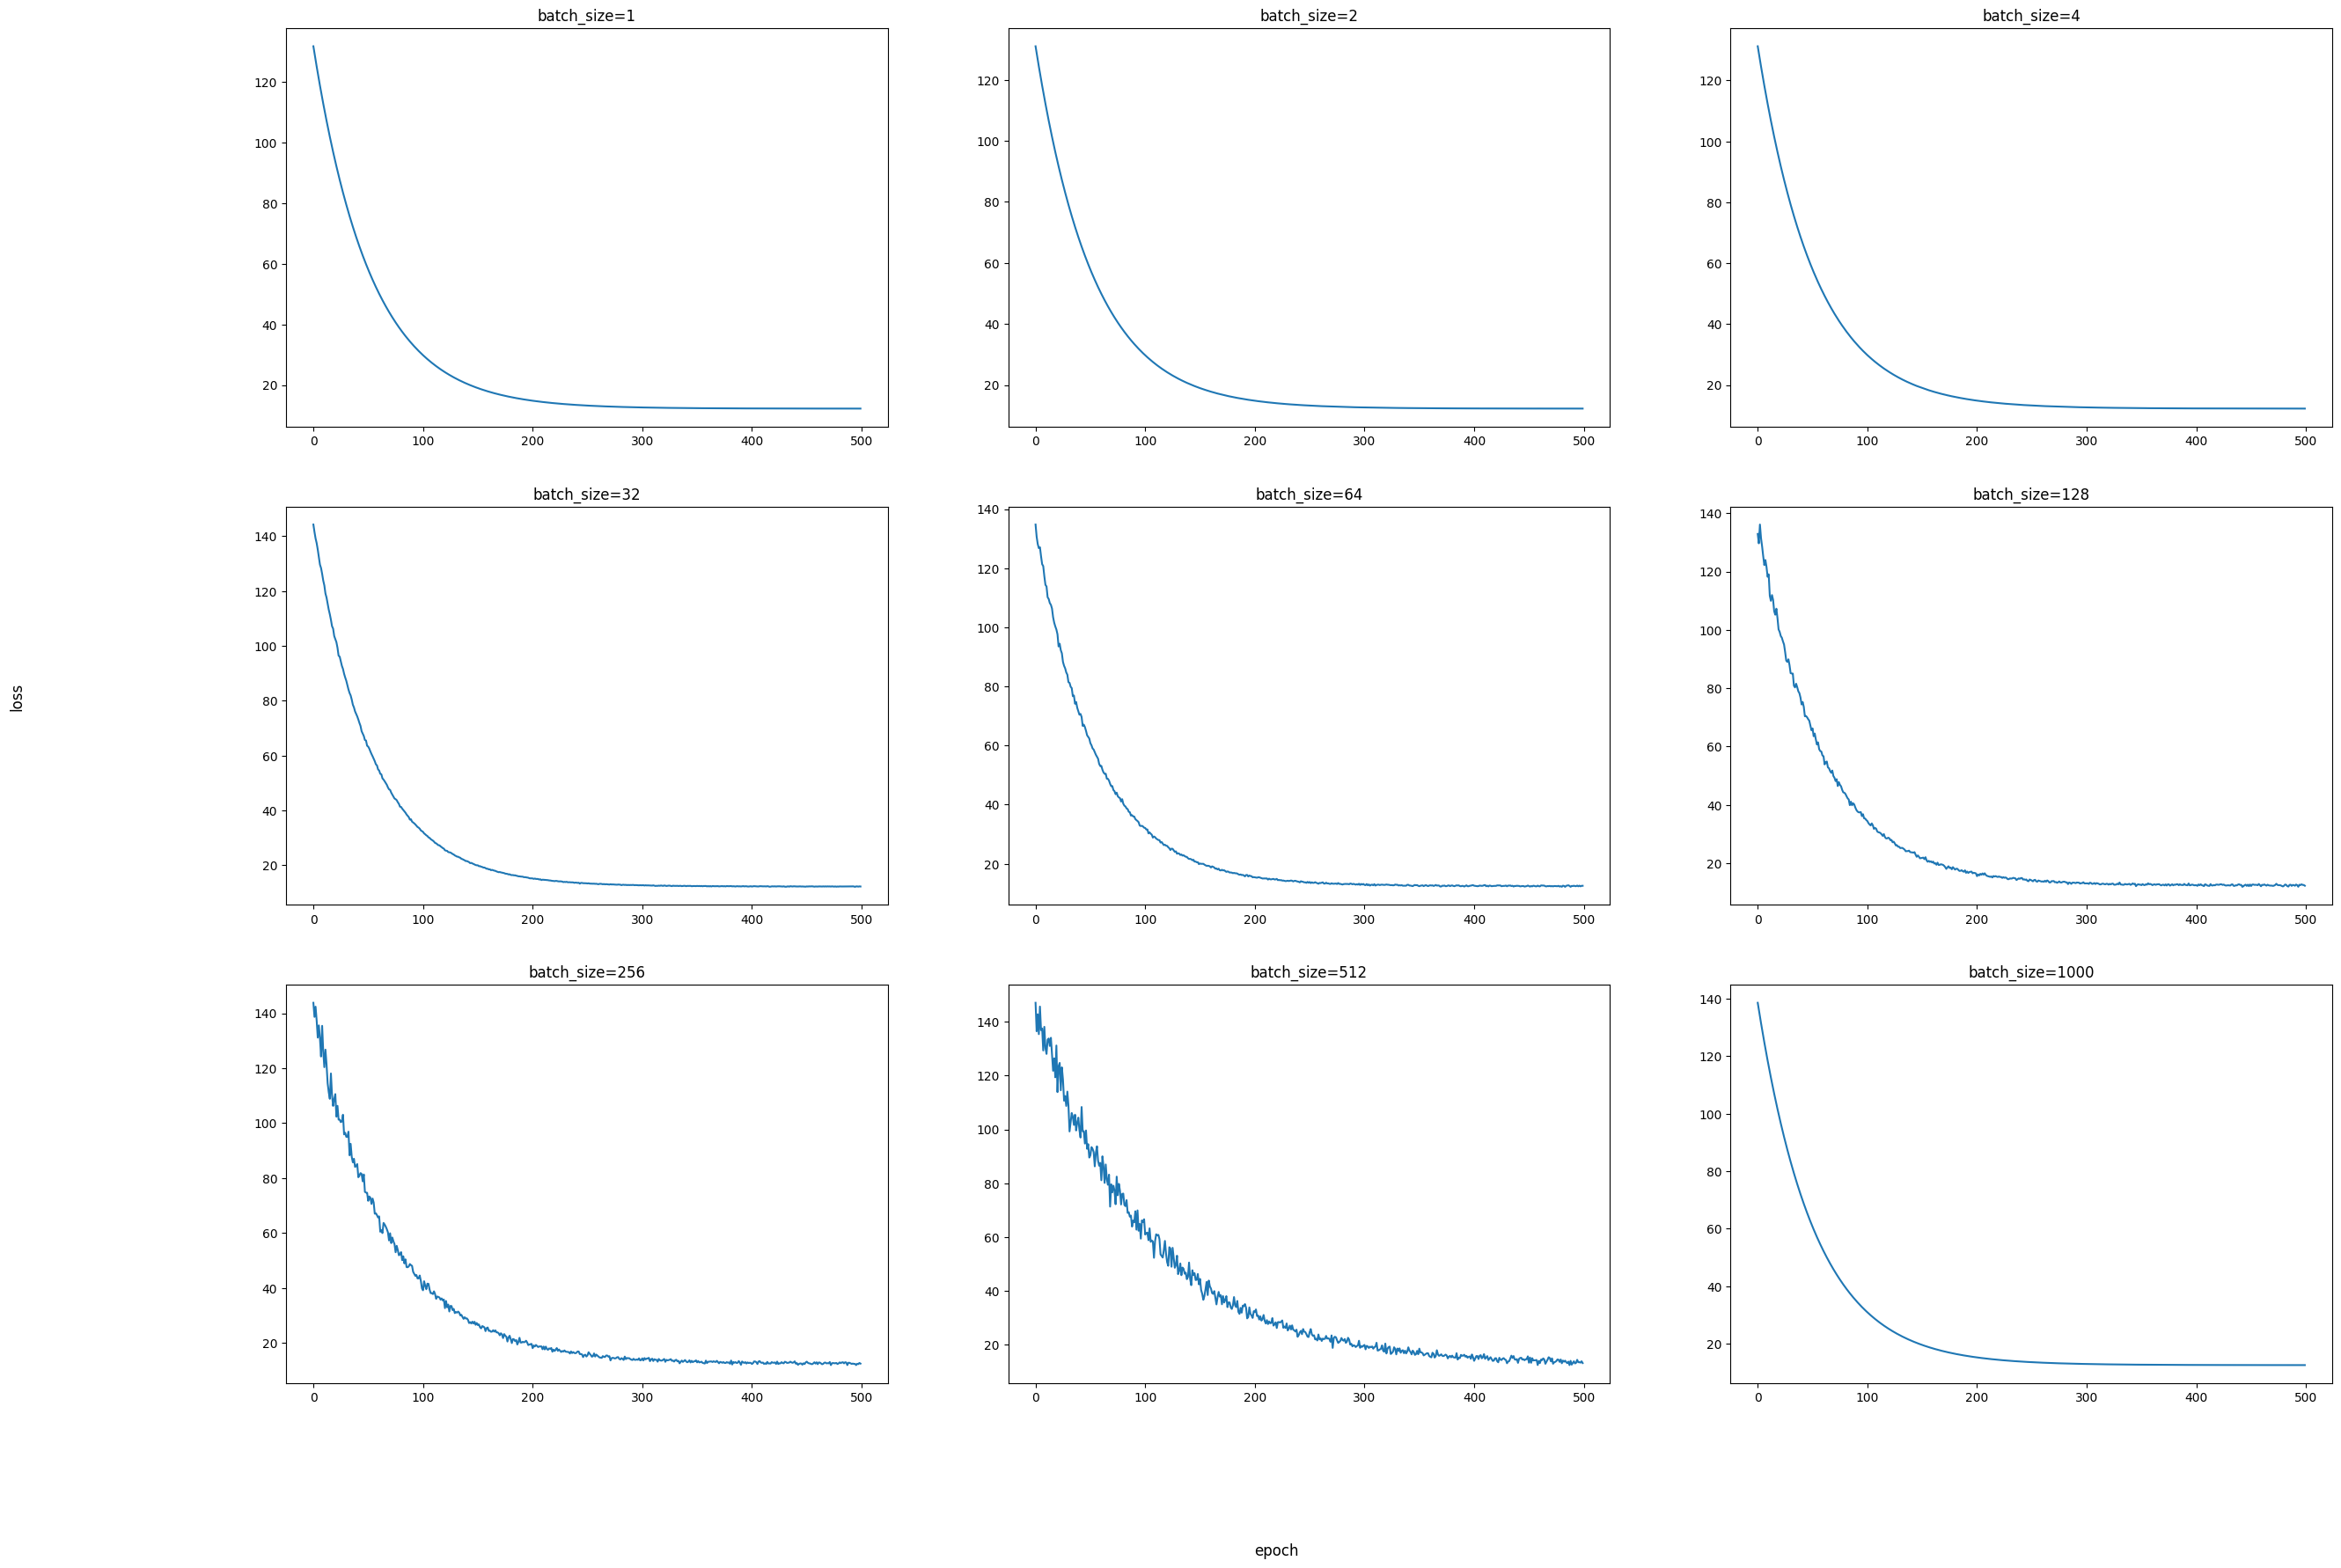

In [6]:
N = 1000
features = 1

data_x, data_y = make_regression(n_samples=N, n_features=features, noise=5, random_state=42)

init_lr = 0.01

epoch = 500

data = []

batch_sizes = [1, 2, 4, 32, 64, 128, 256, 512, N]

width = 3
height = math.ceil(len(batch_sizes) // width)

# print(len(batch_sizes))


fig, axs = plt.subplots(height, width)
fig.set_size_inches(30, 20)
fig.supxlabel('epoch')
fig.supylabel('loss')
for i, batch_size in enumerate(batch_sizes):
    # print(f'{batch_size=}')
    axs[i // width, i % width].set_title(f'{batch_size=}')
    # print(f"============{batch_size=} {gamma=}============")
    model = SGD(data_x, data_y, learning_rate=init_lr, batch_size=batch_size, features=features, N = N)
    model.train(epoch)
    # axs[j // 2, j % 2].set(xlabel='Number of steps')
    # axs[j // 2, j % 2].set(ylabel='Loss')
    axs[i // width, i % width].plot(model.loss_history)

## Задание 3

In [7]:
class LinearRegression(object):
  def __init__(self, data_x, data_y, dims=1, method='sgd', learning_rate=0.001, momentum=0.9):
    assert method in ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam', 'nesterov']
    self.method = method
    self.w = np.random.uniform(size=dims)
    self.b = np.random.uniform(size=1)
    # print(f"w_init: {self.w}")
    # print(f"b_init: {self.b}")
      
    self.cnt = 0
    self.x = data_x
    self.y = data_y
    self.lr = learning_rate
    
    if self.method == 'momentum' or self.method == 'nesterov':
      self.momentum = momentum
      self.vw = 0.0
      self.vb = 0.0
      
    if self.method == 'adagrad':
      self.dw_squared = 0.1
      self.db_squared = 0.1
      self.epsilon = 1e-7
      
    if self.method == 'rmsprop':
      self.dw_squared = 0.0
      self.db_squared = 0.0
      self.decay = 0.9
      self.epsilon = 1e-10
      
    if self.method == 'adam':
      self.dw_first_moment = 0.0
      self.dw_second_moment = 0.0
      self.db_first_moment = 0.0
      self.db_second_moment = 0.0
      self.beta1 = 0.99
      self.beta2 = 0.999
      self.epsilon = 1e-8
    
    # for accumulation of loss and path (w, b)
    self.loss_history = []
    self.w_history = []
    self.b_history = []
  
  def inference(self, x):
    # print(f"{x.shape=}")
    # print(f"{self.w.shape=}")
    # print(f"{self.b.shape=}")
    y_pred = x @ self.w + self.b
    return y_pred
  
  def loss_for_plot(self, w, b):
    y_pred = np.matmul(np.expand_dims(self.x, axis=1), np.expand_dims(w, axis=0)) + b
    loss_for_plot = 0.5 * (y_pred - np.expand_dims(self.y, axis=1))**2
    loss_for_plot = np.mean(loss_for_plot, axis=0)
    return loss_for_plot
  
  def loss_fn(self, labels, predictions):
    loss = 0.5 * np.mean(np.sqrt((predictions - labels)**2))
    return loss
  
  def loss_derivative(self, x, y, y_pred):
    y_diff = y_pred - y
    # print(f'{y_diff.shape=}')
    # print(f'{inputs.shape=}')
    dw = (1.0 / len(self.x)) * np.matmul(np.transpose(x), y_diff)
    # dw = np.mean((y_pred - y) @ x)
    db = (1.0 / len(self.x)) * y_diff
    return dw, db
  
  def weights_update(self):
    self.w = self.w - self.lr * self.dw
    self.b = self.b - self.lr * self.db
    self.uw = - self.lr * self.dw
    self.ub = - self.lr * self.db
    
  def weights_update_momentum(self):
    self.vw = self.momentum * self.vw + self.dw
    self.w = self.w - self.lr * self.vw
    self.vb = self.momentum * self.vb + self.db
    self.b = self.b - self.lr * self.vb
    self.uw = self.vw
    self.ub = self.vb
    
  def weights_update_nesterov(self):
    self.vw = self.momentum * self.vw - self.lr * self.dw
    self.w = self.w + self.vw
    self.vb = self.momentum * self.vb - self.lr * self.db
    self.b = self.b + self.vb
    self.uw = self.vw
    self.ub = self.vb
    
  def weights_update_adagrad(self):
    self.dw_squared = self.dw_squared + self.dw**2
    self.w = self.w - self.lr * self.dw / (np.sqrt(self.dw_squared) + self.epsilon)
    self.db_squared = self.db_squared + self.db**2
    self.b = self.b - self.lr * self.db / (np.sqrt(self.db_squared) + self.epsilon)
    self.uw = - self.lr * self.dw / (np.sqrt(self.dw_squared) + self.epsilon)
    self.ub = - self.lr * self.db / (np.sqrt(self.db_squared) + self.epsilon)
    
  def weights_update_rmsprop(self):
    self.dw_squared = self.decay * self.dw_squared + (1. - self.decay) * self.dw**2
    self.w = self.w - self.lr * self.dw / (np.sqrt(self.dw_squared) + self.epsilon)
    self.db_squared = self.decay * self.db_squared + (1. - self.decay) * self.db**2
    self.b = self.b - self.lr * self.db / (np.sqrt(self.db_squared) + self.epsilon)
    self.uw = - self.lr * self.dw / (np.sqrt(self.dw_squared) + self.epsilon)
    self.ub = - self.lr * self.db / (np.sqrt(self.db_squared) + self.epsilon)
    
  def weights_update_adam(self, time):
    self.dw_first_moment = self.beta1 * self.dw_first_moment + (1. - self.beta1) * self.dw
    self.dw_second_moment = self.beta2 * self.dw_second_moment + (1. - self.beta2) * self.dw**2
    self.db_first_moment = self.beta1 * self.db_first_moment + (1. - self.beta1) * self.db
    self.db_second_moment = self.beta2 * self.db_second_moment + (1. - self.beta2) * self.db**2
    
    self.dw_first_moment_unbiased = self.dw_first_moment / (1. - self.beta1**time)
    self.dw_second_moment_unbiased = self.dw_second_moment / (1. - self.beta2**time)
    self.db_first_moment_unbiased = self.db_first_moment / (1. - self.beta1**time)
    self.db_second_moment_unbiased = self.db_second_moment / (1. - self.beta2**time)
    
    self.w = self.w - self.lr * self.dw_first_moment_unbiased / (np.sqrt(self.dw_second_moment_unbiased) + self.epsilon)
    self.b = self.b - self.lr * self.db_first_moment_unbiased / (np.sqrt(self.db_second_moment_unbiased) + self.epsilon)
    
    self.uw = - self.lr * self.dw_first_moment_unbiased / (np.sqrt(self.dw_second_moment_unbiased) + self.epsilon)
    self.ub = - self.lr * self.db_first_moment_unbiased / (np.sqrt(self.db_second_moment_unbiased) + self.epsilon)
    
    
  def history_update(self, loss, w, b):
    self.loss_history.append(loss)
    self.w_history.append(w)
    self.b_history.append(b)
    
  def update_grad_cnt(self):
    self.cnt += 1
    
  def get_cnt(self):
    return self.cnt


  def train(self, max_epochs):
    pre_loss = 0.0
    # print(f"epochs: {0}  w: {self.w}  b: {self.b}")
    for epoch in range(max_epochs):
      self.y_pred = self.inference(self.x)
      self.loss = self.loss_fn(self.y, self.y_pred)
      self.history_update(self.loss, self.w, self.b)
            
      self.dw, self.db = self.loss_derivative(self.x, self.y, self.y_pred)
      self.update_grad_cnt()
      if self.method == 'momentum':
        self.weights_update_momentum()
      if self.method == 'nesterov':
        self.weights_update_nesterov()
      elif self.method == 'adagrad':
        self.weights_update_adagrad()
      elif self.method == 'rmsprop':
        self.weights_update_rmsprop()
      elif self.method == 'adam':
        self.weights_update_adam(epoch+1)
      else:
        self.weights_update()
        
      # if epoch % 10 == 0:
      #   print(f"epoch: {epoch}  loss: {self.loss:.6f}")
      
      if np.abs(pre_loss - self.loss) < 1e-6:
        self.loss = self.loss_fn(self.y, self.y_pred)
        self.history_update(self.loss, self.w, self.b)
        break
      pre_loss = self.loss
    
    

In [8]:
variants = ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam', 'nesterov']
max_epochs = 5000

In [9]:
def generate_data(a, b, size):
    low = -3.0
    high = 4.0
    data_x = np.random.uniform(low=low, high=high, size=size)
    data_y = np.zeros(size)
    for i, x in enumerate(data_x):
      scale = - (x - low) * (x - high) / 24. + 0.1
      data_y[i] = a * x + b + np.random.normal(loc=0.0, scale=scale, size=1)
    return data_x, data_y

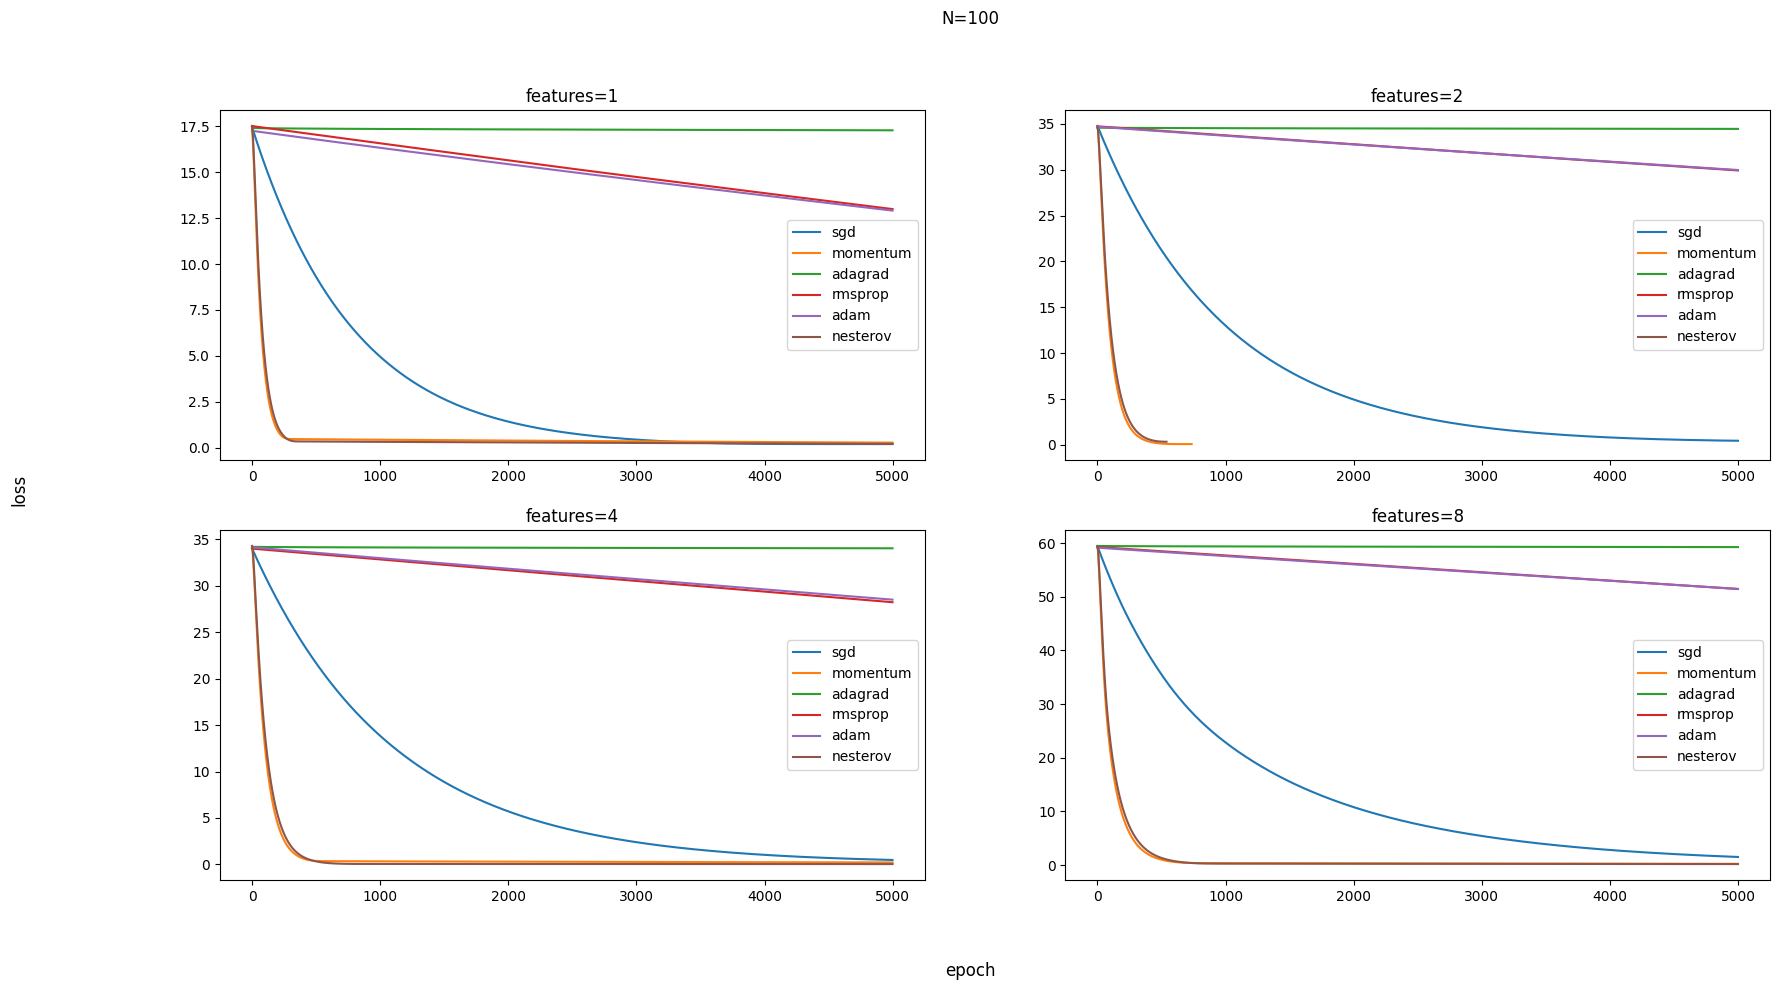

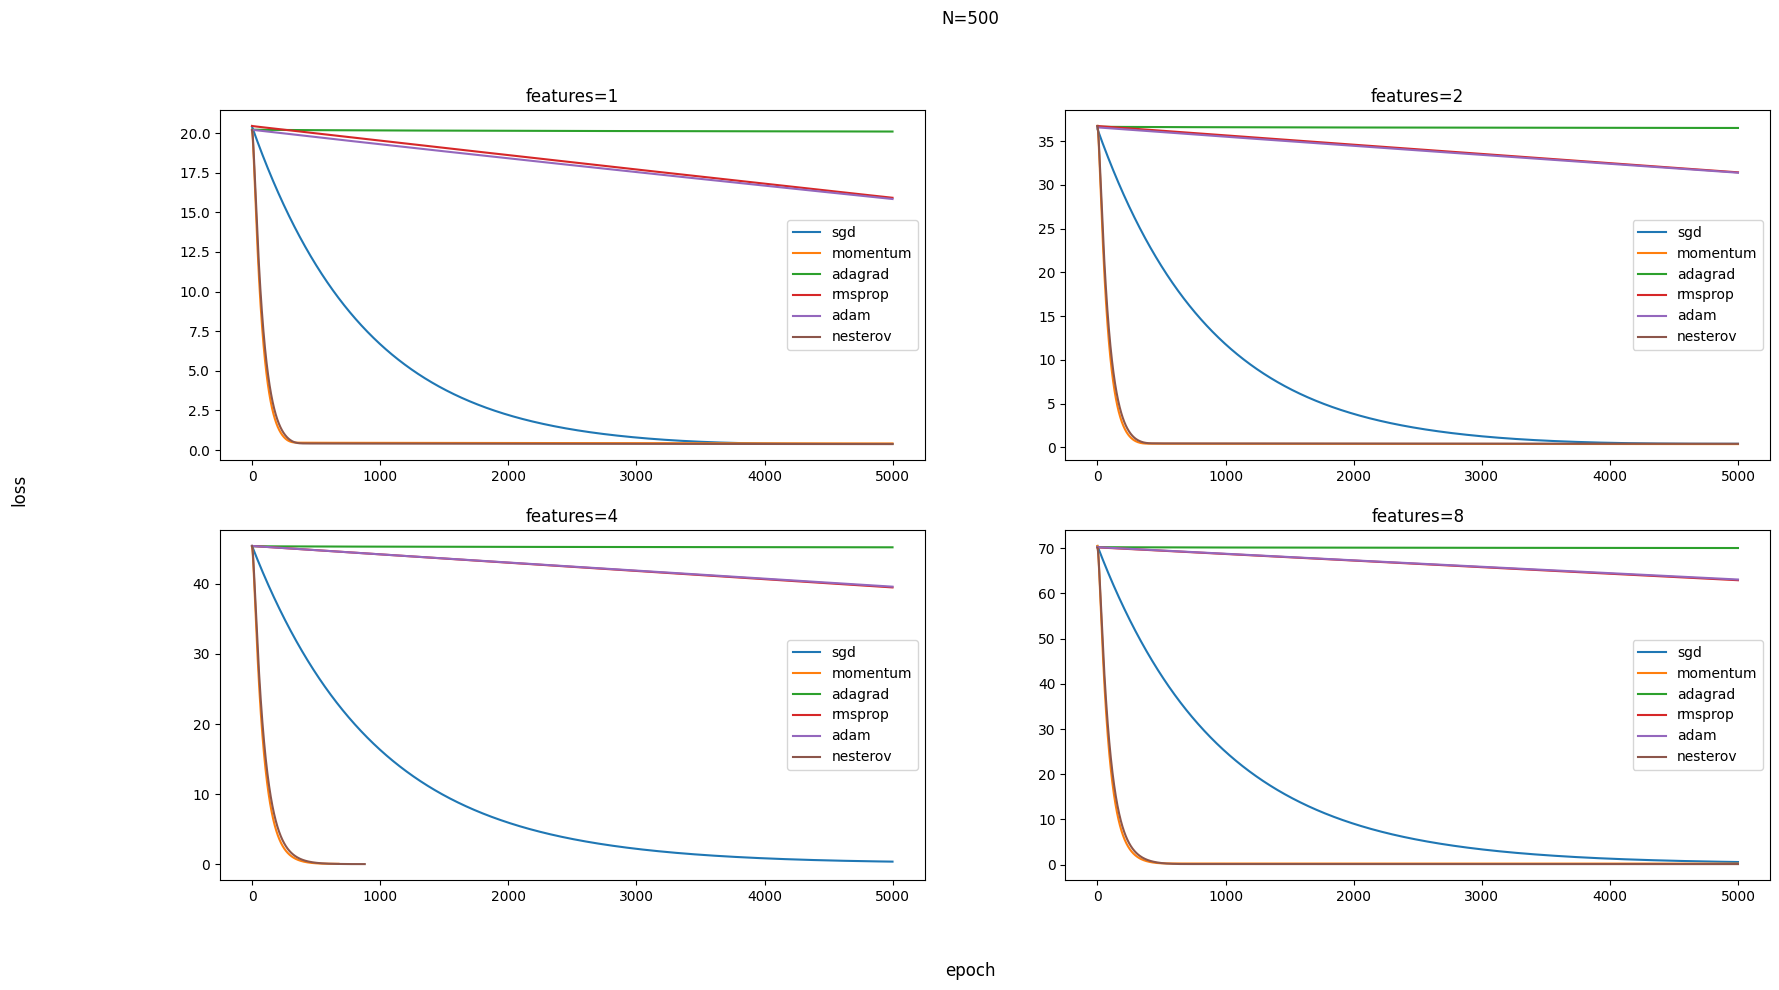

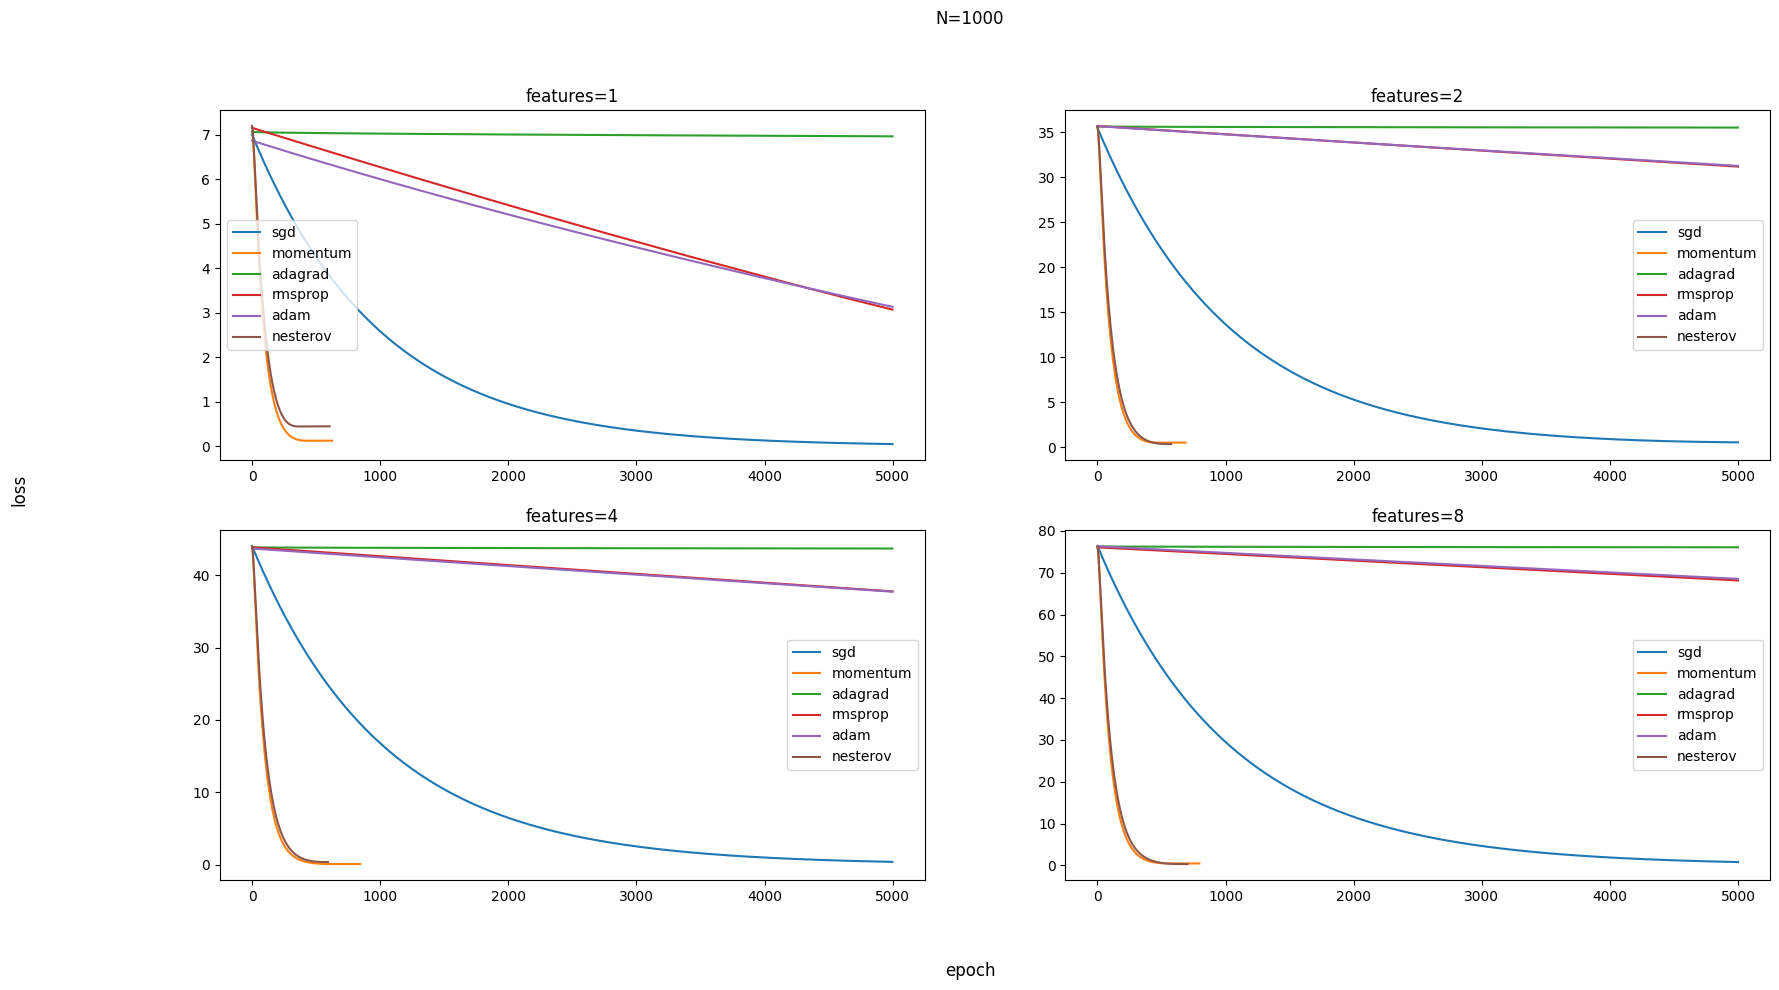

In [10]:
for i, N in enumerate([100, 500, 1000]):
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(f'{N=}')
    fig.supxlabel('epoch')
    fig.supylabel('loss')
    fig.set_size_inches(20, 10)
    for j, features in enumerate([1, 2, 4, 8]):
        data_x, data_y = make_regression(n_samples=N, n_features=features)
        models = [LinearRegression(data_x, data_y, features,variant) for variant in variants]
        for model in models:
            model.train(max_epochs)
        axs[j // 2, j % 2].set_title(f'{features=}')
        for idx, variant in enumerate(variants):
            # print(variant)
            axs[j // 2, j % 2].plot(models[idx].loss_history, label=variant)
            axs[j // 2, j % 2].legend()
    plt.show()

## 4 Задание

In [11]:
from memory_profiler import memory_usage, profile
import gc

In [12]:
%load_ext memory_profiler

In [13]:
N = 1000
features = 8
data_x, data_y = make_regression(n_samples=N, n_features=features)

In [14]:
variants = ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam', 'nesterov']

In [15]:
for variant in variants:
    model = LinearRegression(data_x, data_y, features, variant)
    print(variant)
    %timeit model.train(max_epochs)
    %memit model.train(max_epochs)
    print(model.get_cnt())
    gc.collect()

sgd
76.5 µs ± 8.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
peak memory: 1737.12 MiB, increment: 0.00 MiB
168152
momentum
82.6 µs ± 872 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
peak memory: 1708.20 MiB, increment: 0.00 MiB
84148
adagrad
220 ms ± 6.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 1027.09 MiB, increment: 1.00 MiB
45000
rmsprop
240 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 1027.21 MiB, increment: 0.00 MiB
45000
adam
287 ms ± 9.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 1027.21 MiB, increment: 0.00 MiB
45000
nesterov
71.6 µs ± 739 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
peak memory: 1703.25 MiB, increment: 0.00 MiB
166867


## Задание 5

In [16]:
class Function(object):
  def __init__(self, method, function, gradients, x_init=None, y_init=None, learning_rate=0.01):
    assert method in ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam', 'nesterov']
    
    self.method = method
    self.velocity = np.zeros([2])
    
    self.lr = learning_rate
    
    if self.method == 'momentum' or self.method == 'nesterov':
      self.momentum = 0.9
      
    if self.method == 'adagrad':
      self.dw_squared = 0.1
      self.db_squared = 0.1
      self.epsilon = 1e-7
      self.lr = 0.2
      
    if self.method == 'rmsprop':
      self.dw_squared = 0.0
      self.db_squared = 0.0
      self.decay = 0.9
      self.epsilon = 1e-10
      
    if self.method == 'adam':
      self.grads_first_moment = np.zeros([2])
      self.grads_second_moment = np.zeros([2])
      self.beta1 = 0.99
      self.beta2 = 0.999
      self.epsilon = 1e-8
  
    self.f = function
    self.g = gradients
    scale = 3.0
    self.vars = np.zeros([2])
    if x_init is not None:
      self.vars[0] = x_init
    else:
      self.vars[0] = np.random.uniform(low=-scale, high=scale)
    if y_init is not None:
      self.vars[1] = y_init
    else:
      self.vars[1] = np.random.uniform(low=-scale, high=scale)
    print("x_init: {:.3f}".format(self.vars[0]))
    print("y_init: {:.3f}".format(self.vars[1]))
    
    self.grads_squared = np.zeros([2])
    self.epsilon = 1e-7
    
    # for accumulation of loss and path (w, b)
    self.z_history = []
    self.x_history = []
    self.y_history = []
  
  
  def func(self, variables):
    """Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      z: Beale function value at (x, y)
    """
    x, y = variables
    z = self.f(x, y)
    return z
  
  def gradients(self, variables):
    """Gradient of Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
        dx: gradient of Beale function with respect to x-dimension of inputs
        dy: gradient of Beale function with respect to y-dimension of inputs
    """
    x, y = variables
    grads = self.g(x, y)
    return grads
  
  def weights_update(self, grads):
    self.vars = self.vars - self.lr * grads
    
  def weights_update_momentum(self, grads):
    self.velocity = self.momentum * self.velocity - self.lr * grads
    self.vars = self.vars + self.velocity
    
  def weights_update_nesterov(self, grads):
    velocity_prev = self.velocity
    self.velocity = self.momentum * self.velocity - self.lr * grads
    self.vars = self.vars + self.velocity + self.momentum * (self.velocity - velocity_prev)
    
  def weights_update_adagrad(self, grads):
    self.grads_squared = self.grads_squared + grads**2
    self.vars = self.vars - self.lr * grads / (np.sqrt(self.grads_squared) + self.epsilon)
    
  def weights_update_rmsprop(self, grads):
    self.grads_squared = self.decay * self.grads_squared + (1. - self.decay) * grads**2
    self.vars = self.vars - self.lr * grads / (np.sqrt(self.grads_squared) + self.epsilon)
    
  def weights_update_adam(self, grads, time):
    self.grads_first_moment = self.beta1 * self.grads_first_moment + \
                              (1. - self.beta1) * grads
    self.grads_second_moment = self.beta2 * self.grads_second_moment + \
                              (1. - self.beta2) * grads**2
    
    self.grads_first_moment_unbiased = self.grads_first_moment / (1. - self.beta1**time)
    self.grads_second_moment_unbiased = self.grads_second_moment / (1. - self.beta2**time)
    
    self.vars = self.vars - self.lr * self.grads_first_moment_unbiased /(np.sqrt(self.grads_second_moment_unbiased) + self.epsilon)
    
    
  def history_update(self, z, x, y):
    """Accumulate all interesting variables
    """
    self.z_history.append(z)
    self.x_history.append(x)
    self.y_history.append(y)


  def train(self, max_steps):
    pre_z = 0.0
    # print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(0, self.func(self.vars), self.x, self.y))
    
    file = open('adagrad.txt', 'w')
    file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
    
    for step in range(max_steps):
      self.z = self.func(self.vars)
      self.history_update(self.z, self.x, self.y)

      self.grads = self.gradients(self.vars)
      if self.method == 'momentum':
        self.weights_update_momentum(self.grads)
      if self.method == 'nesterov':
        self.weights_update_nesterov(self.grads)
      elif self.method == 'adagrad':
        self.weights_update_adagrad(self.grads)
      elif self.method == 'rmsprop':
        self.weights_update_rmsprop(self.grads)
      elif self.method == 'adam':
        self.weights_update_adam(self.grads, step+1)
      else:
        self.weights_update(self.grads)
      file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
      
      if (step+1) % 100 == 0:
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}  dx: {:.5f}  dy: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y, self.dx, self.dy))
        
      if np.abs(pre_z - self.z) < 1e-7:
        # print("Enough convergence")
        # print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y))
        self.z = self.func(self.vars)
        self.history_update(self.z, self.x, self.y)
        break
        
      pre_z = self.z
    file.close()

    self.x_history = np.array(self.x_history)
    self.y_history = np.array(self.y_history)
    self.path = np.concatenate((np.expand_dims(self.x_history, 1), np.expand_dims(self.y_history, 1)), axis=1).T
    
    
  @property
  def x(self):
    return self.vars[0]
  
  @property
  def y(self):
    return self.vars[1]
  
  @property
  def dx(self):
    return self.grads[0]
  
  @property
  def dy(self):
    return self.grads[1]

In [17]:
f = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [18]:
def gradients(x, y):
  dx = 2. * ( (1.5 - x + x * y) * (y - 1) + \
                (2.25 - x + x * y**2) * (y**2 - 1) + \
                (2.625 - x + x * y**3) * (y**3 - 1) )
  dy = 2. * ( (1.5 - x + x * y) * x + \
              (2.25 - x + x * y**2) * 2. * x * y + \
              (2.625 - x + x * y**3) * 3. * x * y**2 )
  grads = np.array([dx, dy])
  return grads

In [19]:
opts = [Function(variant, f, gradients, x_init=0.7, y_init=1.4, learning_rate=0.01) for variant in variants]
for opt in opts:
    opt.train(1000)

x_init: 0.700
y_init: 1.400
x_init: 0.700
y_init: 1.400
x_init: 0.700
y_init: 1.400
x_init: 0.700
y_init: 1.400
x_init: 0.700
y_init: 1.400
x_init: 0.700
y_init: 1.400
steps: 100  z: 0.096636  x: 2.44472  y: 0.32327  dx: -0.41345  dy: -0.16275
steps: 200  z: 0.021728  x: 2.69244  y: 0.41208  dx: -0.15311  dy: -0.04974
steps: 300  z: 0.007734  x: 2.80373  y: 0.44659  dx: -0.08138  dy: -0.02408
steps: 400  z: 0.003281  x: 2.86728  y: 0.46488  dx: -0.04962  dy: -0.01390
steps: 500  z: 0.001523  x: 2.90744  y: 0.47594  dx: -0.03243  dy: -0.00878
steps: 600  z: 0.000746  x: 2.93424  y: 0.48311  dx: -0.02207  dy: -0.00583
steps: 700  z: 0.000377  x: 2.95272  y: 0.48795  dx: -0.01541  dy: -0.00401
steps: 800  z: 0.000195  x: 2.96573  y: 0.49132  dx: -0.01094  dy: -0.00281
steps: 900  z: 0.000103  x: 2.97502  y: 0.49370  dx: -0.00786  dy: -0.00200
steps: 1000  z: 0.000055  x: 2.98172  y: 0.49540  dx: -0.00569  dy: -0.00144
steps: 100  z: 0.021352  x: 3.46164  y: 0.59512  dx: 0.07113  dy: 0.012

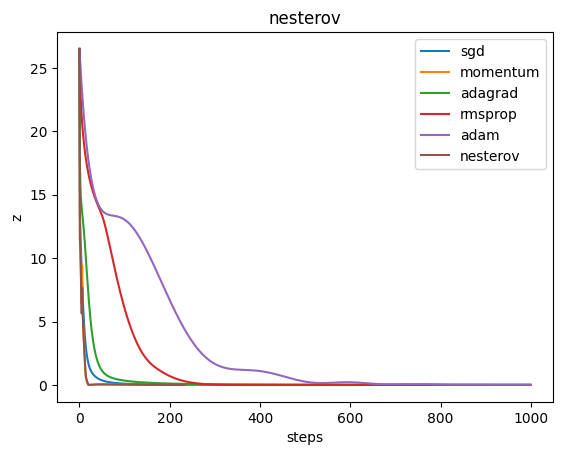

In [20]:
for idx, variant in enumerate(variants):
    plt.title(f'{variant}')
    plt.xlabel('steps')
    plt.ylabel('z')
    plt.plot(opts[idx].z_history, label=variant)
plt.legend()
plt.show()

### График

In [21]:
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

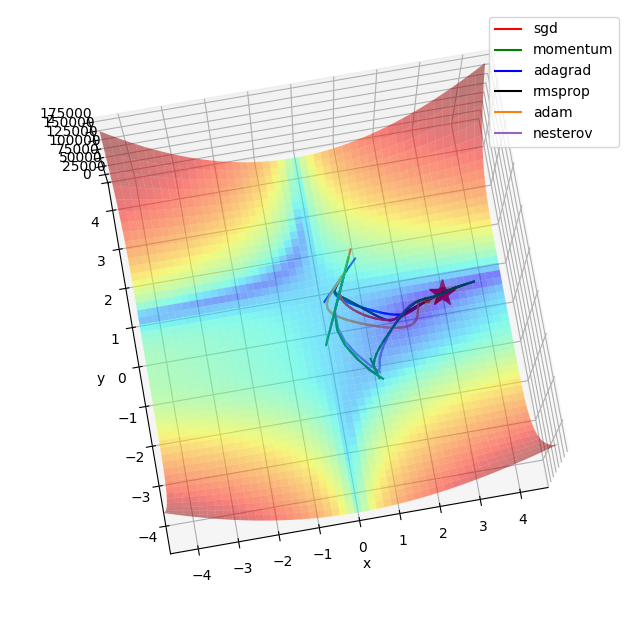

In [22]:
from matplotlib.colors import LogNorm

variants = ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam', 'nesterov']
colors = ['r', 'g', 'b', 'k', 'tab:orange', 'tab:purple']

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=80, azim=-100)

minima = np.array([3, 0.5])
ax.plot_surface(x_mesh, y_mesh, z, rstride=1, norm=LogNorm(),  cstride=1, 
                    edgecolor='none', alpha=.5, cmap=plt.cm.jet)
ax.plot(*minima, f(*minima), 'r*', markersize=20)
    
for idx,variant in enumerate(variants):
    path = opts[idx].path
    
    ax.quiver(path[0,:-1], path[1,:-1], opt.func([*path[::,:-1]]),
              path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
              opt.func([*path[::,1:]]) - opt.func([*path[::,:-1]]),
              length=1, color=colors[idx], label=variant)

    plt.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#plt.draw()
plt.show()

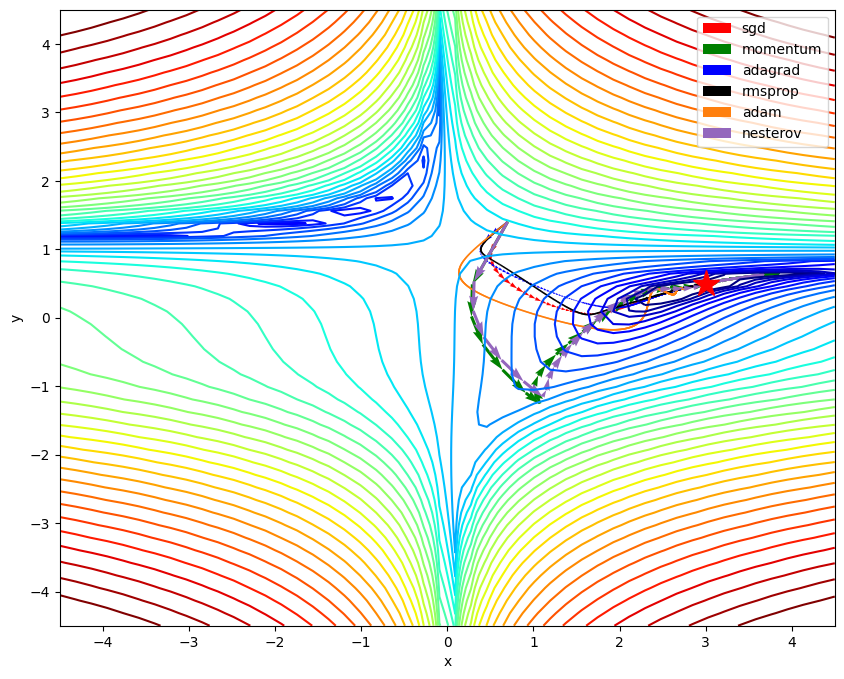

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)


for idx,variant in enumerate(variants):
    path = opts[idx].path
    
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          scale_units='xy', angles='xy', scale=1, color=colors[idx], label=variant)

    plt.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

plt.show()